In [1]:
module('load', 'pytorch/gpu-cuda-12.1/2.2.0')

Loading pytorch/gpu-cuda-12.1/2.2.0
  Loading requirement: cuda/12.1 cudnn/8.9.2


In [2]:
!export CUDA_LAUNCH_BLOCKING=1


In [3]:
from sensitivity_map import SensMapImageLoader

cuda


In [4]:

#def __init__(self, main_masses_data, substructure_data, precomputed_data, source_data, lens_grid, device, dtype=torch.float32):


In [5]:
import torch

data = torch.load("../../catalogs/resamp_theta2.pth")

# manually building main lens data

manual_main_data={
    "PEMD":{
        "param_map": ['pos_x', 'pos_y', 'redshift', 'vel_disp', 'slope', 'orient', 'q'],
        "params":torch.tensor([[0.0, 0.0, 3.0, 300., 1.0, 0.0, 0.8]], device="cuda"),
        "sys_idx": torch.tensor([0], device="cuda")
    }
}


# data1 = filter_first_sys(data, sys=1)
# data0 = filter_first_sys(data, sys=0)

precomp_data={
    "sys_idx":torch.tensor([0], device="cuda"),
    "params":torch.tensor([[1.2098e+03, 1.7824e+03, 1.1709e+03, 5.7433e-06]], device="cuda"),
    "param_map":['D_l', 'D_s', 'D_ls', 'Theta_E']
}

source_data={
    "Gaussian_blob":{
        "sys_idx": torch.tensor([0], device="cuda"),
        "params": torch.tensor([[0.0, 0.0, 1.0, 0.0, 0.8, 0.8, 3.0]], device="cuda"),
        "param_map":['position_rad_x', 'position_rad_y','I','orient_rad','q','std_kpc','redshift']
    }

}


sub_params=torch.tensor([[-1.2683e-05,  2.7299e-08,  1.0000e+12,  9.2402e+00,  4.4041e-01],
                         [-1.2683e-05,  2.7299e-08,  1.0000e+11,  9.2402e+00,  4.4041e-01],
                         [-1.2683e-05,  2.7299e-08,  1.0000e+10,  9.2402e+00,  4.4041e-01],
                         [-1.2683e-05,  2.7299e-08,  1.0000e+9,  9.2402e+00,  4.4041e-01],
                         [-1.2683e-05,  2.7299e-08,  1.0000e+8,  9.2402e+00,  4.4041e-01]
                        ], device="cuda").repeat(100, 1)
sub_params_map=['pos_x', 'pos_y', 'mass_max', 'r_max_kpc', 'redshift']



sub_data={
    "pix_tuple": [(0, 0)],
    "index_abs": [0, 1],
    "pix_idx": [0],
    "mass_type": "NFW",
    "params": sub_params,
    "params_map": sub_params_map
}

from shared_utils import _grid_lens
lens_grid=_grid_lens(8.0, 100, device="cuda")


my_image_loader= SensMapImageLoader( 
    main_masses_data=manual_main_data, 
    substructure_data=sub_data, 
    precomputed_data=precomp_data, 
    source_data=source_data, 
    lens_grid=lens_grid, 
    device="cuda", 
    dtype=torch.float32
)

In [46]:

#substructure data is a dictionary having keys ["pix_tuple", "index_abs", "pix_idx", "mass_type", "params", "params_map"]

main_lens_dict={
    "system_index": 0,
    "precomputed": {
        "D_l": 895.141641604983,
        "D_s": 1719.2297595274565,
        "D_ls": 1383.4035047295204,
        "Theta_E": 5.931095815829854e-06
    },
    "lens_model": {
        "num_substructures": 1,
        "mass_components": [
            {
                "type": "PEMD",
                "is_substructure": False,
                "params": {
                    "pos": [
                        0.0,
                        0.0
                    ],
                    "redshift": 0.27630325852132565,
                    "vel_disp": 229.76100223115105,
                    "slope": 0.825713219064535,
                    "orient": [
                        1.8219410700100875
                    ],
                    "q": [
                        0.7696236448774971
                    ]
                }
            }
        ]
    },
    "source_model": {
        "type": "Gaussian_blob",
        "params": {
            "I": 1.0,
            "position_rad": [
                5.7680415247008e-07,
                -1.1513580580248836e-07
            ],
            "orient_rad": 0.0,
            "q": 0.8,
            "std_kpc": 1.4,
            "redshift": 2.4019740198871116
        }
    }
}


sub_dict={
    "type": "NFW",
    "is_substructure": True,
    "params": {
        "pos": [
            -4.633905994729479e-06,
            1.0418124529340142e-05
        ],
        "mass_max": 99999999999.9998,
        "r_max_kpc": 3.031994721038995,
        "redshift": 0.27630325852132565
    }
}


import torch
from collections import defaultdict
from pathlib import Path

def helper(main_lens_dict, substructure_dict, position_mesh_grid, tested_masses_tensor):


    # 1) parameter‐order maps
    precomp_map = ["D_l", "D_s", "D_ls", "Theta_E"]
    mass_param_map = {
        "SIS":        ["pos_x","pos_y","redshift","vel_disp"],
        "NFW":        ["pos_x","pos_y","mass_max","r_max_kpc","redshift"],
        "ExternalPotential": ["shear_x","shear_y","shear_strength","shear_angle_arcsec"],
        "PEMD":       ["pos_x","pos_y","redshift","vel_disp","slope","orient","q"],
    }
    source_param_map = {
        "Gaussian_blob": ["position_rad_x","position_rad_y","I","orient_rad","q","std_kpc","redshift"]
    }

    device = "cuda"
    sys_idx_val = main_lens_dict.get("system_index", 0)

    # --- Precomputed data ---
    pre_params = [main_lens_dict["precomputed"][key] for key in precomp_map]
    precomp_data = {
        "sys_idx": torch.tensor([sys_idx_val], device=device),
        "param_map": precomp_map,
        "params": torch.tensor([pre_params], device=device)
    }

    # --- Main lens mass components ---
    main_mass_data = {}
    for comp in main_lens_dict["lens_model"]["mass_components"]:
        if not comp.get("is_substructure", False):
            t = comp["type"]
            param_map = mass_param_map[t]
            vals = []
            params = comp["params"]
            for name in param_map:
                if name == "pos_x":
                    vals.append(params["pos"][0])
                elif name == "pos_y":
                    vals.append(params["pos"][1])
                else:
                    v = params.get(name)
                    vals.append(v[0] if isinstance(v, list) else v)
            main_mass_data[t] = {
                "sys_idx": torch.tensor([sys_idx_val], device=device),
                "param_map": param_map,
                "params": torch.tensor([vals], device=device)
            }

    # --- Source model ---
    src = main_lens_dict["source_model"]
    src_type = src["type"]
    s_map = source_param_map[src_type]
    sval = []
    s_params = src["params"]
    for name in s_map:
        if name == "position_rad_x":
            sval.append(s_params["position_rad"][0])
        elif name == "position_rad_y":
            sval.append(s_params["position_rad"][1])
        else:
            v = s_params.get(name)
            sval.append(v)
    source_data = {
        src_type: {
            "sys_idx": torch.tensor([sys_idx_val], device=device),
            "param_map": s_map,
            "params": torch.tensor([sval], device=device)
        }
    }

    # 4) Substructure data
    mtype = substructure_dict["type"]
    sub_map = mass_param_map[mtype]
        # Base substructure params vector (extract from 'pos' and other keys)
    sparams = substructure_dict["params"]
    base_vals = []
    for name in sub_map:
        if name == "pos_x":
            base_vals.append(sparams["pos"][0])
        elif name == "pos_y":
            base_vals.append(sparams["pos"][1])
        else:
            base_vals.append(sparams[name])
    base_params = torch.tensor(base_vals, device=device)

    # Flatten position grid to Nx2 to Nx2
    pos = position_mesh_grid
    if pos.dim() > 2 and pos.size(-1) == 2:
        orig_shape = tuple(pos.shape[:-1])
        pos_flat = pos.view(-1, 2)
    elif pos.dim() == 2 and pos.size(-1) == 2:
        orig_shape = (pos.shape[0],)
        pos_flat = pos
    else:
        raise ValueError("position_mesh_grid must have last dimension=2")

    Npix = tested_masses_tensor.numel()
    pos_flat = pos_flat[:Npix]

    # Broadcast base params and override pos_x, pos_y, mass_max
    params_mat = base_params.unsqueeze(0).repeat(Npix, 1)
    idx_px = sub_map.index("pos_x")
    idx_py = sub_map.index("pos_y")
    params_mat[:, idx_px] = pos_flat[:, 0]
    params_mat[:, idx_py] = pos_flat[:, 1]
    if "mass_max" in sub_map:
        idx_m = sub_map.index("mass_max")
        params_mat[:, idx_m] = tested_masses_tensor.to(device)

    # Pixel tuples (row, col) or unravel indices
    flat_idx = torch.arange(Npix, device=device)
    if len(orig_shape) == 2:
        rows = flat_idx // orig_shape[1]
        cols = flat_idx % orig_shape[1]
        pix_tuple = torch.stack([rows, cols], dim=1)
    else:
        unr = torch.unravel_index(flat_idx, orig_shape)
        pix_tuple = torch.stack(unr, dim=1)

    pix_idx = torch.zeros(Npix, dtype=torch.long, device=device)
    index_abs = flat_idx.clone()

    sub_data = {
        "pix_tuple": pix_tuple,
        "pix_idx": pix_idx,
        "index_abs": index_abs,
        "mass_type": mtype,
        "params": params_mat,
        "params_map": sub_map
    }

    return precomp_data, main_mass_data, source_data, sub_data



In [47]:

from shared_utils import _grid_lens
lens_grid=_grid_lens(8.0, 100, device="cuda")


precomp_data, main_mass_data, source_data, sub_data= helper(
    main_lens_dict,
    sub_dict,
    position_mesh_grid=lens_grid,
    tested_masses_tensor=torch.arange(0, 10)
)

In [48]:
print(precomp_data)

print(main_mass_data)

print(source_data)

print(sub_data)

from shared_utils import _grid_lens
lens_grid=_grid_lens(8.0, 100, device="cuda")


my_image_loader= SensMapImageLoader( 
    main_masses_data=main_mass_data, 
    substructure_data=sub_data, 
    precomputed_data=precomp_data, 
    source_data=source_data, 
    lens_grid=lens_grid, 
    device="cuda", 
    dtype=torch.float32
)

{'sys_idx': tensor([0], device='cuda:0'), 'param_map': ['D_l', 'D_s', 'D_ls', 'Theta_E'], 'params': tensor([[8.9514e+02, 1.7192e+03, 1.3834e+03, 5.9311e-06]], device='cuda:0')}
{'PEMD': {'sys_idx': tensor([0], device='cuda:0'), 'param_map': ['pos_x', 'pos_y', 'redshift', 'vel_disp', 'slope', 'orient', 'q'], 'params': tensor([[  0.0000,   0.0000,   0.2763, 229.7610,   0.8257,   1.8219,   0.7696]],
       device='cuda:0')}}
{'Gaussian_blob': {'sys_idx': tensor([0], device='cuda:0'), 'param_map': ['position_rad_x', 'position_rad_y', 'I', 'orient_rad', 'q', 'std_kpc', 'redshift'], 'params': tensor([[ 5.7680e-07, -1.1514e-07,  1.0000e+00,  0.0000e+00,  8.0000e-01,
          1.4000e+00,  2.4020e+00]], device='cuda:0')}}
{'pix_tuple': tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5],
        [0, 6],
        [0, 7],
        [0, 8],
        [0, 9]], device='cuda:0'), 'pix_idx': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), 'index_abs': te

In [50]:
image, something=my_image_loader[0:1]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


cpu shape: torch.Size([50, 100, 100])


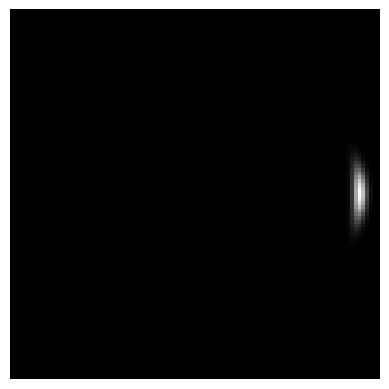

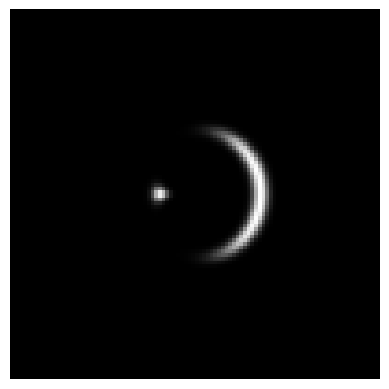

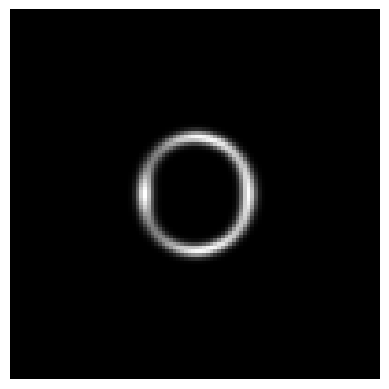

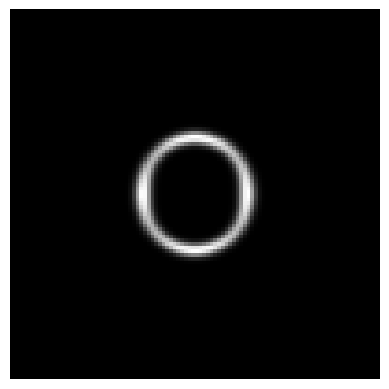

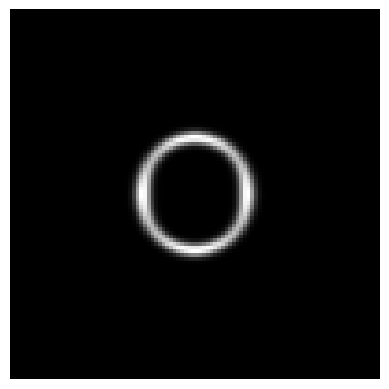

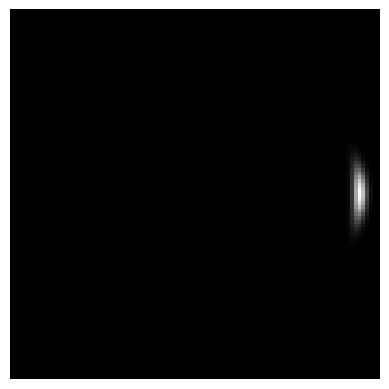

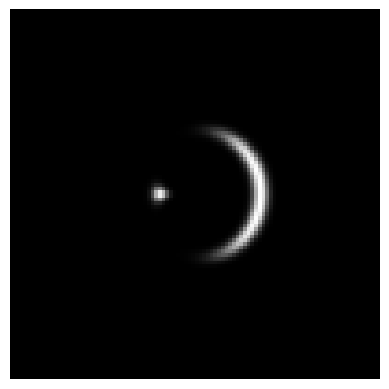

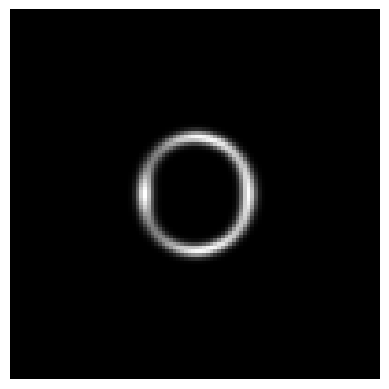

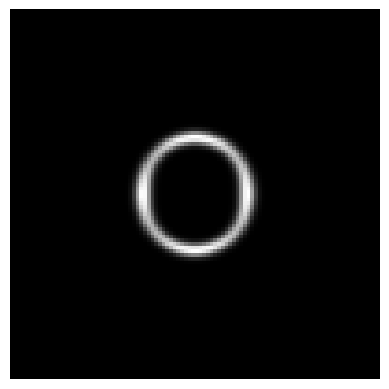

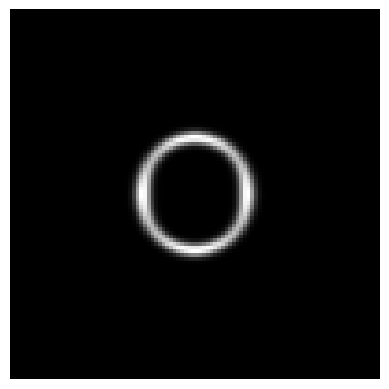

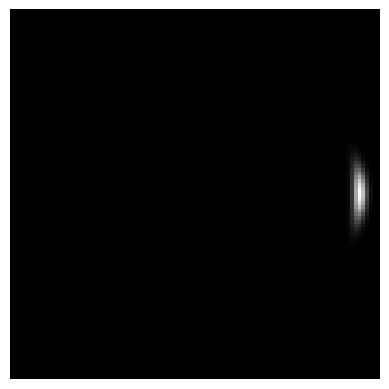

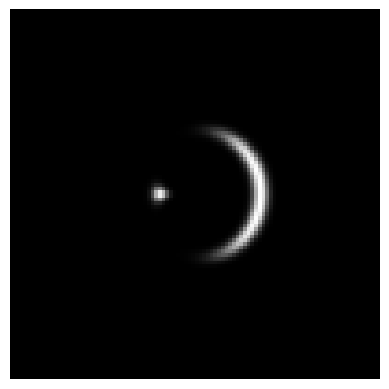

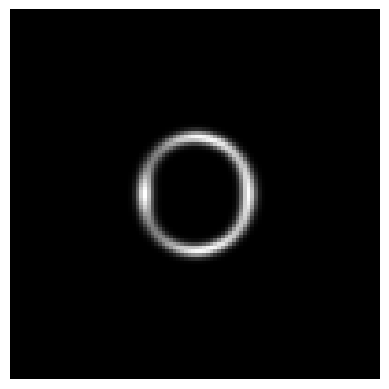

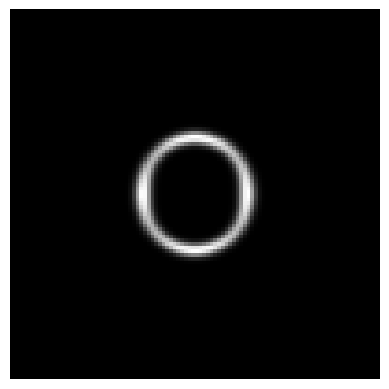

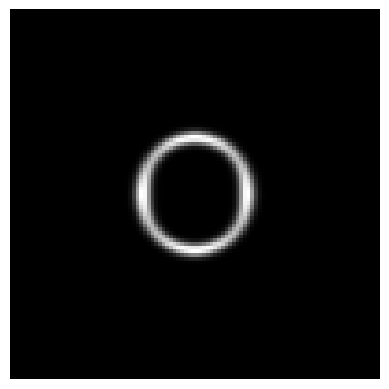

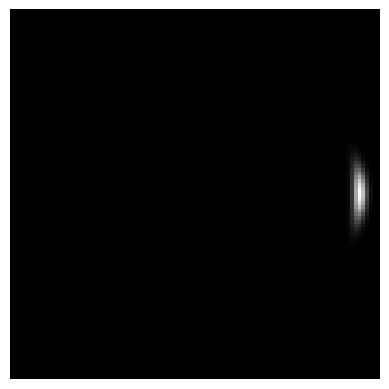

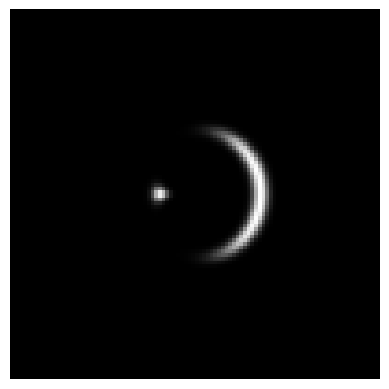

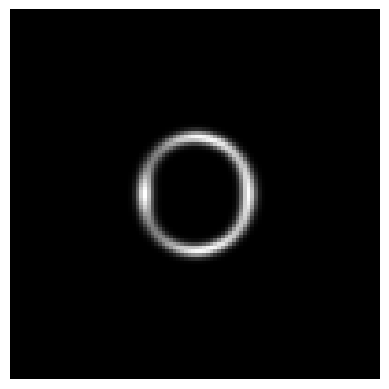

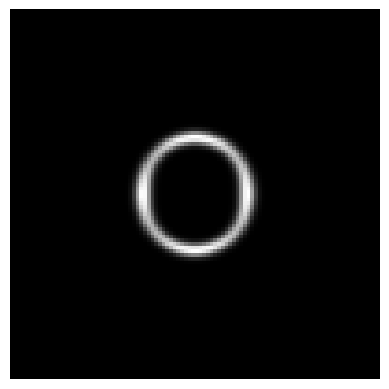

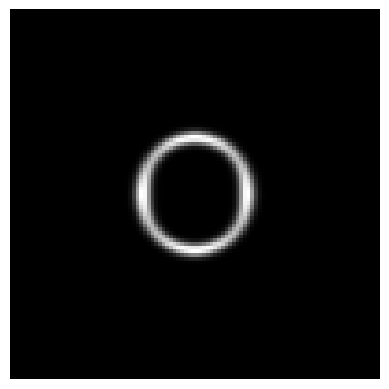

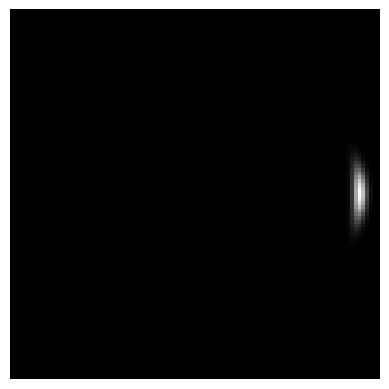

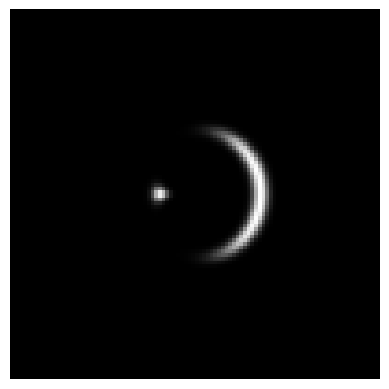

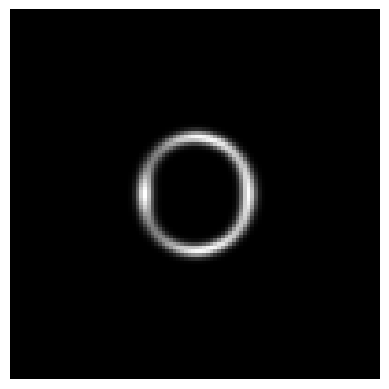

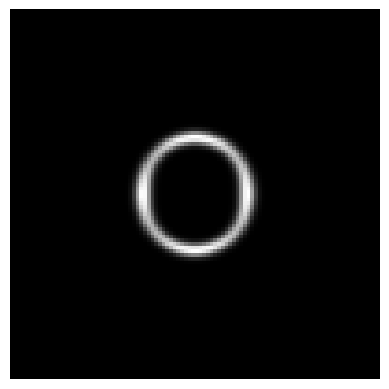

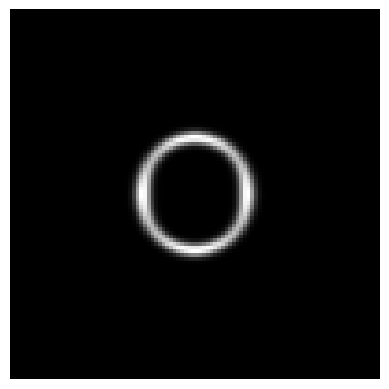

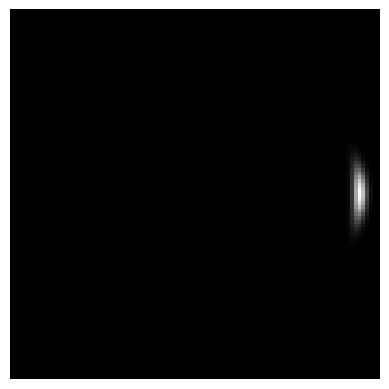

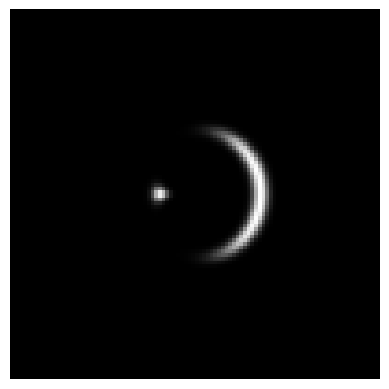

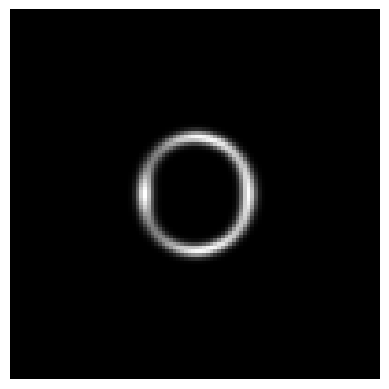

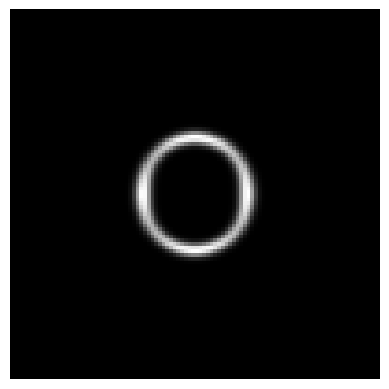

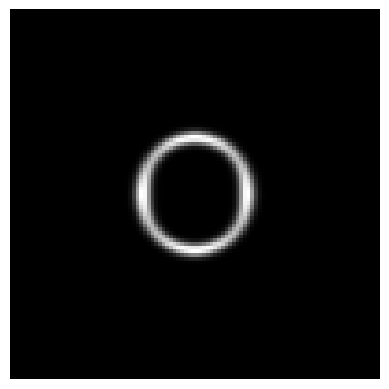

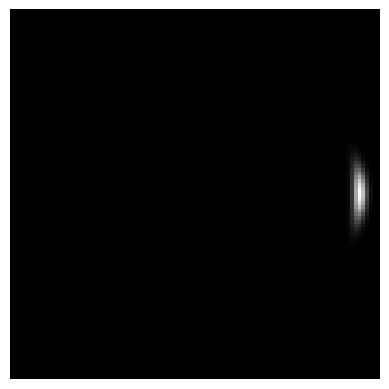

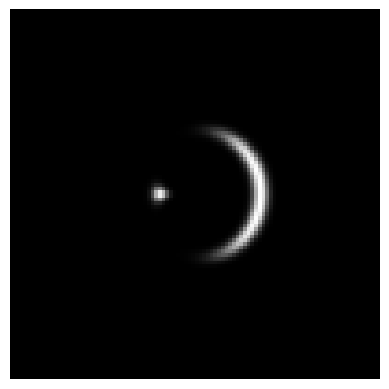

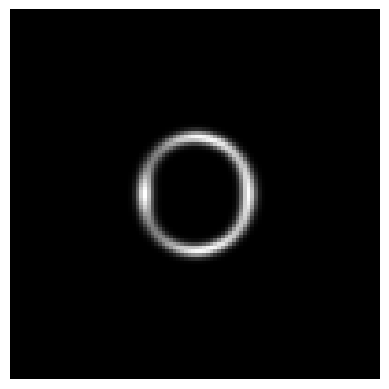

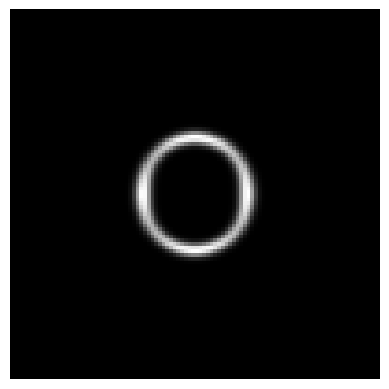

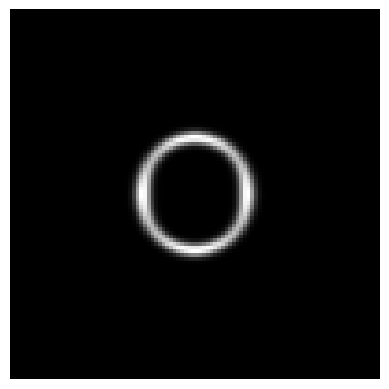

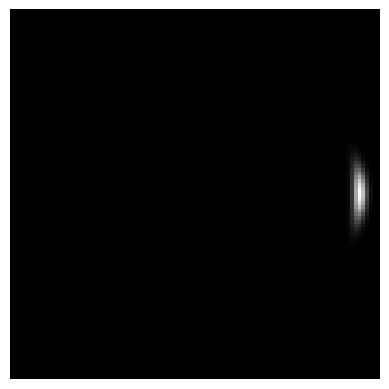

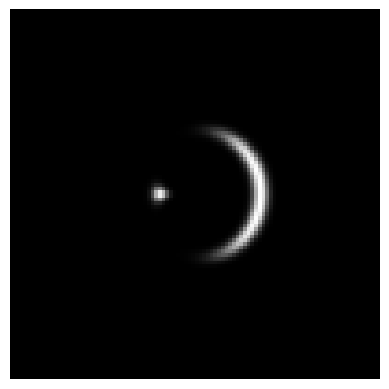

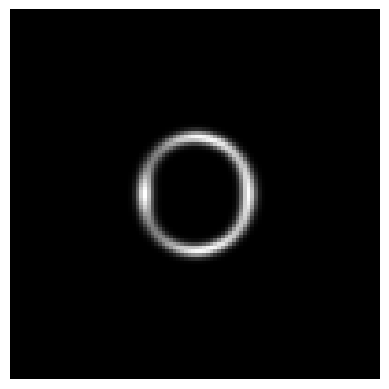

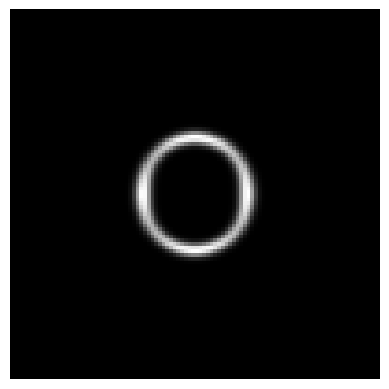

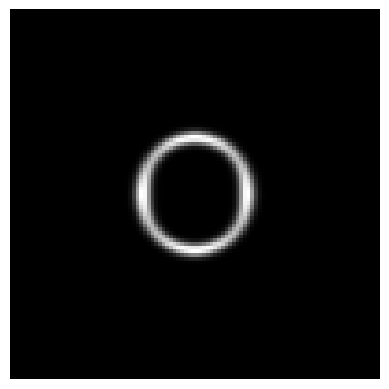

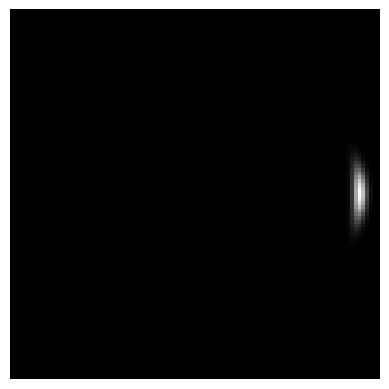

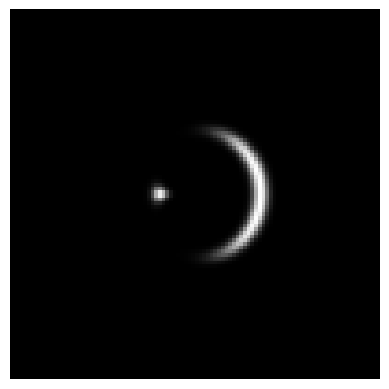

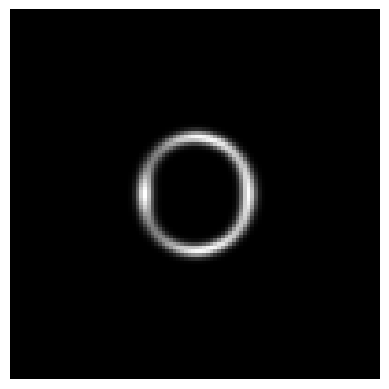

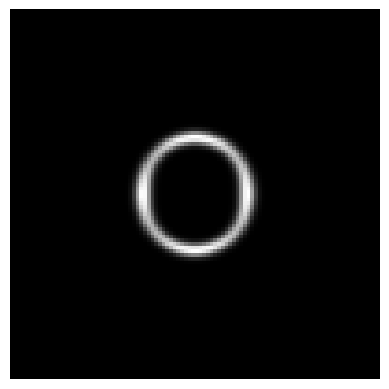

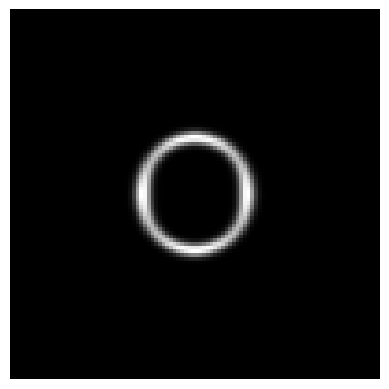

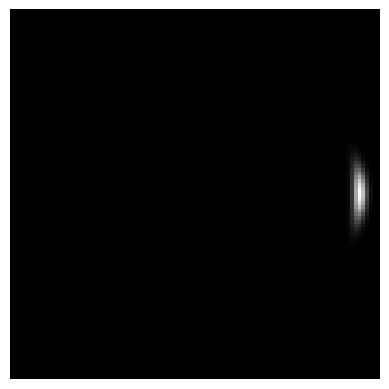

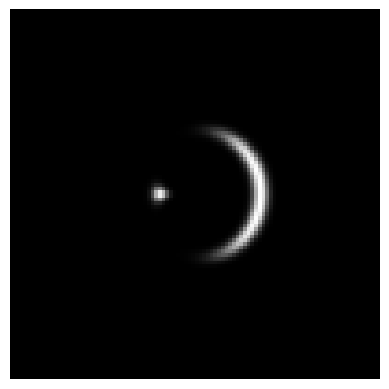

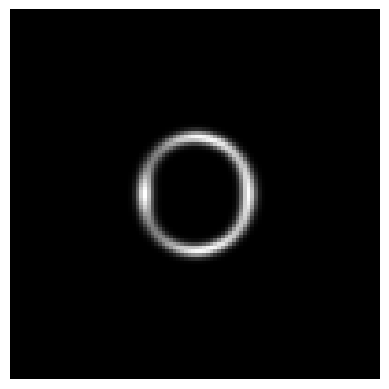

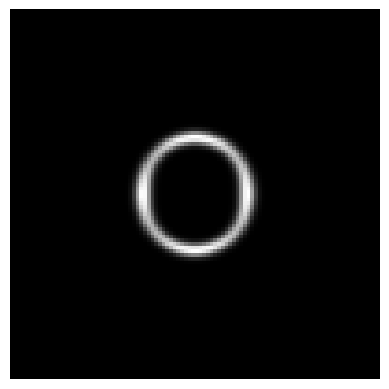

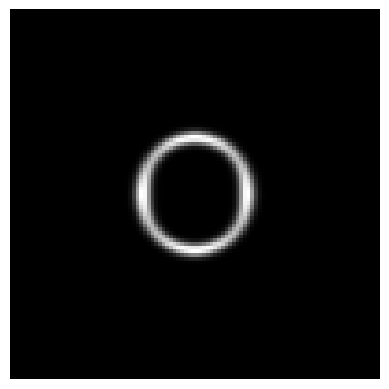

In [8]:
import matplotlib.pyplot as plt

# 1) detach and move to CPU _before_ slicing
img_cpu = image.detach().cpu()  
print("cpu shape:", img_cpu.shape)   # make sure batch dim >= 1

for i in range (50):
    # 2) now index on the CPU
    slice_img = img_cpu[i]              # this will error in Python if batch_size == 0


    # 4) convert to numpy and show
    arr = slice_img.numpy()
    plt.imshow(arr, cmap='gray' if arr.ndim == 2 else None)
    plt.axis('off')
    plt.show()